# Assignment 5 - Applied Machine Learning
---
## Arghadeep Ghosh

This notebook 'Image Classifier.ipynb' contains the code for finetuning a Resnet18 network for chicken and duck classification

In [1]:
# Importing modules

import random, time, glob 
import torch

import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, datasets
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

## Building the DataLoader
---

The data is read from the file as a list of tuple containing the image and its label. The data is transformed and wrapped in a PyTorch DataLoader class

In [2]:
def load_data(split):
    chicken_folder = "./Data/Chicken/"
    duck_folder = "./Data/Duck/"
    
    chicken_data = glob.glob(chicken_folder + "*.jpg", recursive=True)
    duck_data = glob.glob(duck_folder + "*.jpg", recursive=True)
    
    data = []
    for file in chicken_data:
        data += [(Image.open(file).convert('RGB'), 0)]
    for file in duck_data:
        data += [(Image.open(file).convert('RGB'), 1)]
            
    random.shuffle(data)
    
    train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
    return train_data, test_data

train_data, test_data = load_data(0.7)

len(train_data), len(test_data)

(698, 300)

In [3]:
transform = transforms.Compose(
    [  # Applying Augmentation
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
    ]
)  # Normalizing data

class dataloader(Dataset):
    """
    Dataset class to read img file from filepath 
    and return Pillow Image object with its label_id
    """
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.data[index]
        img = img.resize((224,224))
        
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

## Loading the Pre-trained Model
---

The Resnet18 Model is loaded and its final layer is modified to produce a binary classification

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = resnet18(weights = ResNet18_Weights.DEFAULT)

# Locking all Parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Changing last layer of model from 1000 classes to 2 classes
model.fc = nn.Linear(model.fc.in_features, 2)

# Newly added layer has unlocked parameters
# The rest of the parameters will be unlocked after the 3rd epoch
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the Model

---

The model hyperparameters are set and the model is finetuned for the classification task

In [5]:
EPOCHS = 25
BATCH_SIZE = 16
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0007)

train_data =  dataloader(train_data, transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

test_data =  dataloader(test_data, transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

len(train_data)

698

### Loss and Accuracy before Training

TEST LOSS: 0.0441, TEST ACCURACY: 0.6233


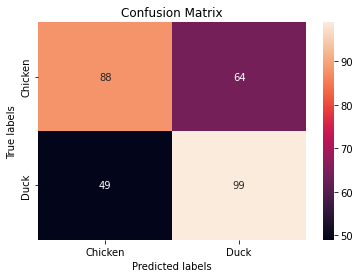

In [6]:
model.eval()
test_loss = 0
test_acc = 0
Y = []
Y_pred = []
for batch_idx, (data, target) in enumerate(test_loader):
    with torch.no_grad():
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        Y += [target.cpu().detach().numpy()]
        Y_pred += [output.cpu().detach().numpy()]
        
        correct = 0
        for p in range(len(data)):
            pred = torch.argmax(output[p])
            if pred == int(target[p]):
                correct = correct + 1

        test_loss += loss
        test_acc += correct

test_loss = test_loss/len(test_data)
test_acc = test_acc/len(test_data)
print(f"TEST LOSS: {test_loss:.4f}, TEST ACCURACY: {test_acc:.4f}")

Y = np.concatenate(Y, axis = 0)
Y_pred = np.argmax(np.concatenate(Y_pred, axis = 0), axis = 1)

cm = confusion_matrix(Y, Y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Chicken', 'Duck']); ax.yaxis.set_ticklabels(['Chicken', 'Duck']);

In [7]:
new_best = 0
for i in range(EPOCHS):
    start = time.time()
    print("="*100)
    print(f"EPOCH: {i}")
    model.train()
    total_loss = 0
    total_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device) 
        target = target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        for p in range(len(data)):
            pred = torch.argmax(output[p])
            if pred == int(target[p]):
                correct += 1
           
        total_loss += loss
        total_acc += correct
        
    avg_loss = total_loss/len(train_data)
    avg_acc = total_acc/len(train_data)

    print(f"TRAINING LOSS: {avg_loss:.4f}, TRAINING ACCURACY: {avg_acc:.4f}")
    
    model.eval()
    test_loss = 0
    test_acc = 0
    
    for batch_idx, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)

            correct = 0
            for p in range(len(data)):
                pred = torch.argmax(output[p])
                if pred == int(target[p]):
                    correct += 1

            test_loss += loss
            test_acc += correct
            
    test_loss = test_loss/len(test_data)
    test_acc = test_acc/len(test_data)
    print(f"TEST LOSS: {test_loss:.4f}, TEST ACCURACY: {test_acc:.4f}")
    
    if test_acc > new_best:
        new_best = test_acc
        torch.save(model, "model")
    

EPOCH: 0
TRAINING LOSS: 0.0584, TRAINING ACCURACY: 0.6103
TEST LOSS: 0.1591, TEST ACCURACY: 0.4933
EPOCH: 1
TRAINING LOSS: 0.1731, TRAINING ACCURACY: 0.5960
TEST LOSS: 0.3490, TEST ACCURACY: 0.5067
EPOCH: 2
TRAINING LOSS: 0.1992, TRAINING ACCURACY: 0.5802
TEST LOSS: 0.3594, TEST ACCURACY: 0.4933
EPOCH: 3
TRAINING LOSS: 0.4341, TRAINING ACCURACY: 0.5129
TEST LOSS: 0.1726, TEST ACCURACY: 0.6567
EPOCH: 4
TRAINING LOSS: 0.1290, TRAINING ACCURACY: 0.7536
TEST LOSS: 0.3404, TEST ACCURACY: 0.5500
EPOCH: 5
TRAINING LOSS: 0.5607, TRAINING ACCURACY: 0.5215
TEST LOSS: 0.3929, TEST ACCURACY: 0.5767
EPOCH: 6
TRAINING LOSS: 0.1836, TRAINING ACCURACY: 0.7665
TEST LOSS: 0.0289, TEST ACCURACY: 0.9300
EPOCH: 7
TRAINING LOSS: 0.2171, TRAINING ACCURACY: 0.7607
TEST LOSS: 0.4409, TEST ACCURACY: 0.6500
EPOCH: 8
TRAINING LOSS: 0.5784, TRAINING ACCURACY: 0.6074
TEST LOSS: 0.5574, TEST ACCURACY: 0.6167
EPOCH: 9
TRAINING LOSS: 0.3005, TRAINING ACCURACY: 0.7507
TEST LOSS: 0.1250, TEST ACCURACY: 0.8633
EPOCH: 10


### Loss and Accuracy after Training

TEST LOSS: 0.0752, TEST ACCURACY: 0.9333


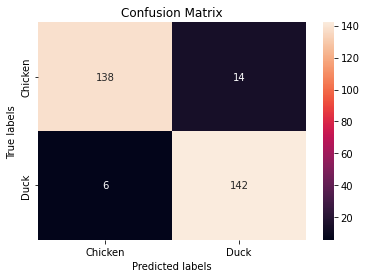

In [8]:
model = torch.load("model")

model.eval()
test_loss = 0
test_acc = 0
Y = []
Y_pred = []
for batch_idx, (data, target) in enumerate(test_loader):
    with torch.no_grad():
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        Y += [target.cpu().detach().numpy()]
        Y_pred += [output.cpu().detach().numpy()]
        
        correct = 0
        for p in range(len(data)):
            pred = torch.argmax(output[p])
            if pred == int(target[p]):
                correct = correct + 1

        test_loss += loss
        test_acc += correct

test_loss = test_loss/len(test_data)
test_acc = test_acc/len(test_data)
print(f"TEST LOSS: {test_loss:.4f}, TEST ACCURACY: {test_acc:.4f}")

Y = np.concatenate(Y, axis = 0)
Y_pred = np.argmax(np.concatenate(Y_pred, axis = 0), axis = 1)

cm = confusion_matrix(Y, Y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Chicken', 'Duck']); ax.yaxis.set_ticklabels(['Chicken', 'Duck']);